#### 1) -> Data overview:

1) -> Data overview:
Total Number of Samples:
             4624 of images for all 3 classes.
             
Classes: 
   Leaf Blast, Bacterial Blight, Brown Spot

2) -> Data Distribution:
 
    Leaf Blast:
         1440 images
   
Bacterial Blight
         15844 images   
Brown Spt:o
         1604 images

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import  tensorflow as tf
from tensorflow.keras import models, layers
%matplotlib inline

In [3]:
IMAGE_SIZE  = 300
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Rice-Leaf-Disease",
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4624 files belonging to 3 classes.


In [5]:
class_name = dataset.class_names
print("Classes names is : {}".format(class_name))

Classes names is : ['Bacterialblight', 'Blast', 'Brownspot']


In [6]:
len(dataset)

145

In [7]:
# lets check how many batches we have
batch_size_of_dataset = len(dataset)
print("Batch size of dataset is : {}".format(batch_size_of_dataset))

Batch size of dataset is : 145


### 4) ->Image Statistics:

In [8]:
# shapes of image data

In [9]:
for image_batch, label_batch in dataset.take(1):
    print("First image shape is :", image_batch[0].shape)
    print("Dataset images shape is :",image_batch.shape)
    print("labels associated with the images in the batch : ", label_batch.numpy())

First image shape is : (300, 300, 3)
Dataset images shape is : (32, 300, 300, 3)
labels associated with the images in the batch :  [2 1 0 1 0 1 0 1 2 0 0 0 0 2 0 2 1 0 2 1 2 2 0 0 2 1 2 0 2 0 2 0]


#### 5)-> Exploratory data analysis:

In [10]:
# lets visualize the data:

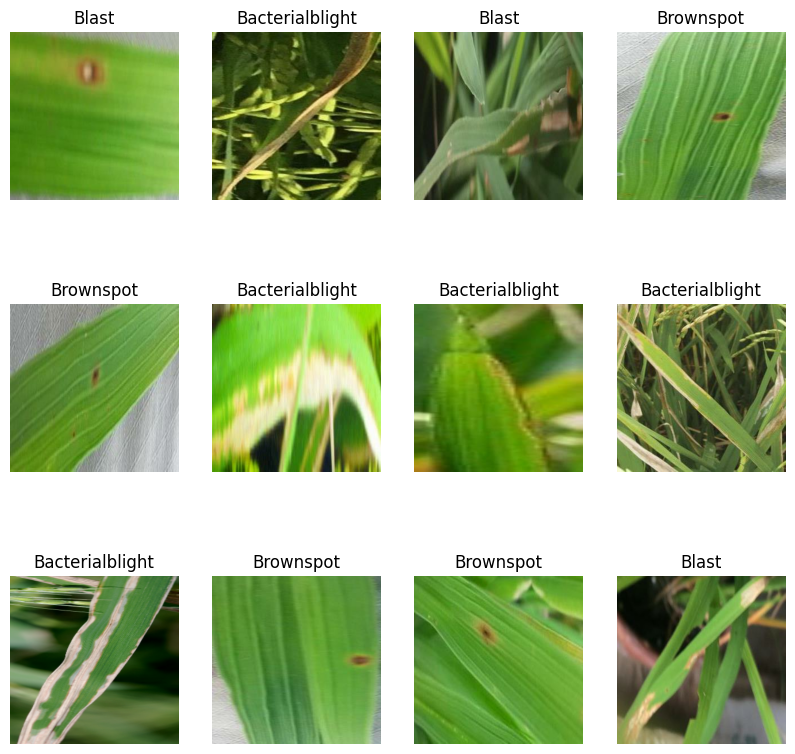

In [11]:
plt.figure(figsize = (10,10))

for image_batch, label_batch in dataset.take(2):

    for i in range(12):
        plt.subplot(3,4,i + 1, xticks = [], yticks = [])
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")


#### 6)-> Data Split:

In [12]:
# split the data into train,test and validation

In [13]:
train_size = 0.8
len(dataset)*train_size

116.0

In [14]:
test_size = 0.1
len(dataset)* test_size

14.5

In [15]:
val_size = 0.1
len(dataset)*val_size

14.5

In [16]:
# split the data train,test, validation_data
def get_dataset_partition_tf(ds, train_split = 0.8, test_split = 0.2, val_split = 0.2, shuffle = True, shuffle_size = (10000)):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split * ds_size)
    test_size = int(test_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    test_ds = ds.take(test_size)
    val_ds = ds.take(val_size)

    return train_ds, test_ds,val_ds

In [17]:
train_ds,test_ds,val_ds = get_dataset_partition_tf(dataset)

In [18]:
len(train_ds)

116

In [19]:
len(test_ds)

29

In [20]:
len(val_ds)

29

#### 7)- > Data Preprocessing:

#### data pipeline optimization:

Data pipeline optimization in a CNN project is like preparing a smooth conveyer belt for your model:
1. **Caching:** It stores the dataset in memory, making it quicker to access during training.
2. **Shuffling:** It mixes up the data order, preventing the model from learning patterns based on the sequence of examples.
3. **Prefetching:** It prepares the next batch in the background while the current one is being processed, reducing idle time.
4. **Efficiency Boost:** Overall, these steps enhance the efficiency of feeding data to the model, making the training process faster and more effective.

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

#### Resize and recale of data:

#### Objective:

Prepare input images for the rice leaf disease prediction model through an effective preprocessing pipeline.

#### Pipeline Components:

Resizing Layer:

layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE)

Resizes input images to a specified dimension (IMAGE_SIZE x IMAGE_SIZE).

Ensures uniformity in input dimensions for effective model processing.

Rescaling Layer:

layers.experimental.preprocessing.Rescaling(1.0/300)

Scales pixel values to a range suitable for neural network processing.
                                       
Normalizes pixel values by dividing them by 300.

Benefits:

Standardizes image dimensions, ensuring compatibility with the model architecture.

Rescaling enhances numerical stability and aids convergence during model training.

Conclusion:

This preprocessing pipeline optimally readies input images, facilitating the model's ability to detect and classify rice leaf diseases accurately.

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/300)
])

**Slide: Data Augmentation for Improved Model Training**

*Title: Enhancing Dataset Diversity*

---

**Objective:**
- Introduce data augmentation techniques to enhance the diversity of the training dataset for improved model generalization.

**Data Augmentation Layers:**
1. **RandomFlip:**
   - Horizontally and vertically flips images randomly.
   - Adds variations to the dataset, making the model more robust.

2. **RandomRotation:**
   - Rotates images randomly by a maximum of 0.2 radians.
   - Introduces rotational diversity, further improving the model's ability to handle variations.

**Benefits:**
- Mitigates overfitting by exposing the model to diverse image transformations during training.
- Increases the model's ability to generalize to unseen data.

**Implementation:**
- Applied as a preprocessing step before feeding images into the neural network.

**Conclusion:**
- Data augmentation contributes to a more versatile and resilient model, ensuring better performance on real-world data.

---



#### data_augmentation:

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

#### Model architecture:

Utilizes a Convolutional Neural Network (CNN) for image classification.

#### layers:

Conv2D (32 filters, 3x3 kernel, 'relu' activation) with MaxPooling.

Conv2D (64 filters, 3x3 kernel, 'relu' activation) with MaxPooling.

Repeated Conv2D and MaxPooling layers for hierarchical feature extraction.

Dropout layer (30% dropout rate) to enhance generalization.

Flatten layer to transition from convolutional to dense layers.

Dense layer (500 neurons, 'relu' activation) with additional dropout.

Output layer with softmax activation for multi-class classification.

#### Summary:

The model employs convolutional layers to capture hierarchical image features.
Dropout layers prevent overfitting by randomly dropping connections during training.
Dense layers enable the network to learn complex patterns.
The softmax activation in the output layer facilitates multi-class classification.

#### Conclusion:

This architecture aims to achieve high accuracy in predicting rice leaf diseases, contributing to early intervention in agriculture.

In [24]:
num_classes = 3
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation ,
    layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(500, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation= 'softmax'),
    
])
model.build(input_shape = (input_shape))

In [25]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 300, 300, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 300, 300, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 300, 300, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 150, 150, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 150, 150, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 75, 75, 64)          0         
 g2D)                                                 


1. **Setting Up Training Configuration**:
   - Compilation configures how the model learns from data during training.
   - It involves specifying optimizer, loss function, and evaluation metrics.
   - These choices affect how the model's parameters are updated and how its performance is measured.

2. **Optimizer Selection**:
   - The optimizer determines how the model's parameters are adjusted based on the loss.
   - Different optimizers have different learning strategies and update rules.
   - Choosing the right optimizer can help the model converge faster and perform better.

3. **Loss Function and Metrics**:
   - The loss function measures how well the model's predictions match the actual target values.
   - Metrics are used to evaluate the model's performance during training and testing.
   - Selecting appropriate loss function and metrics helps in training the model effectively and assessing its performance accurately.

##### compile model:

In [26]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [27]:
# lets create check point
from keras.callbacks import ModelCheckpoint

**Slide: Model Checkpointing for Best Performance**

*Title: Saving the Best Model Weights*

---

**Objective:**
- Implement model checkpointing to save the weights of the best-performing model during training.

**Checkpoint Configuration:**
- **Filepath:** 'model.weights.best.hdf5'
  - Specifies the file path to save the best model weights.

- **Verbose:** 1
  - Displays a progress message when the best weights are saved.

- **Save Best Only:** True
  - Ensures only the weights of the model with the best performance are saved.

**Benefits:**
- Preserves the best model, preventing potential loss of valuable training progress.
- Facilitates model evaluation and comparison based on optimal performance.

**Implementation:**
- Used in conjunction with model training as a callback.

**Conclusion:**
- Model checkpointing is a crucial practice for tracking and preserving the best-performing model weights, ensuring reliable and reproducible results.

---


In [28]:
checkpoint = ModelCheckpoint(filepath='model.weights.best.hdf5',verbose = 1, save_best_only = True)

# Training of Model:

In [29]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint],verbose = 2
)

Epoch 1/30



Epoch 1: val_loss improved from inf to 0.94869, saving model to model.weights.best.hdf5
116/116 - 290s - loss: 1.0886 - accuracy: 0.3850 - val_loss: 0.9487 - val_accuracy: 0.5690 - 290s/epoch - 2s/step
Epoch 2/30


C:\Users\mmakn\.conda\envs\AIandML\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.94869 to 0.72725, saving model to model.weights.best.hdf5
116/116 - 290s - loss: 0.8012 - accuracy: 0.6044 - val_loss: 0.7273 - val_accuracy: 0.6487 - 290s/epoch - 2s/step
Epoch 3/30

Epoch 3: val_loss improved from 0.72725 to 0.70554, saving model to model.weights.best.hdf5
116/116 - 277s - loss: 0.7283 - accuracy: 0.6353 - val_loss: 0.7055 - val_accuracy: 0.6336 - 277s/epoch - 2s/step
Epoch 4/30

Epoch 4: val_loss improved from 0.70554 to 0.63411, saving model to model.weights.best.hdf5
116/116 - 281s - loss: 0.6413 - accuracy: 0.6929 - val_loss: 0.6341 - val_accuracy: 0.6843 - 281s/epoch - 2s/step
Epoch 5/30

Epoch 5: val_loss improved from 0.63411 to 0.48835, saving model to model.weights.best.hdf5
116/116 - 293s - loss: 0.5438 - accuracy: 0.7681 - val_loss: 0.4883 - val_accuracy: 0.7888 - 293s/epoch - 3s/step
Epoch 6/30

Epoch 6: val_loss improved from 0.48835 to 0.36095, saving model to model.weights.best.hdf5
116/116 - 293s - loss: 0.4148 - acc

In [30]:
 model.load_weights('model.weights.best.hdf5')

##### Model Evaluation:

In [31]:
score = model.evaluate(test_ds)

29/29 [==============================] - 21s 458ms/step - loss: 1.7549e-04 - accuracy: 1.0000


In [32]:
score

[0.0001754873082973063, 1.0]

### Accuracy History through all epochs:

In [33]:
history.history['accuracy']

[0.38501080870628357,
 0.6044372320175171,
 0.6352813839912415,
 0.6929112672805786,
 0.7681276798248291,
 0.8260281682014465,
 0.8517315983772278,
 0.8812229633331299,
 0.9096320271492004,
 0.9339826703071594,
 0.9369588494300842,
 0.9591450095176697,
 0.9594155550003052,
 0.9688853025436401,
 0.961309552192688,
 0.9834956526756287,
 0.9921537041664124,
 0.9840368032455444,
 0.9926947951316833,
 0.9853895902633667,
 0.9791666865348816,
 0.9924242496490479,
 0.9623917937278748,
 0.9778138399124146,
 0.987554132938385,
 0.9859307408332825,
 0.9986472129821777,
 0.9997294545173645,
 1.0,
 1.0]

#### check history used in each epochs:

In [34]:
parameter  = history.params

print("Parameter used for each epochs : {}".format(parameter))

Parameter used for each epochs : {'verbose': 2, 'epochs': 30, 'steps': 116}


##### Keys of each params:

In [35]:
keys = history.history.keys()
print("Keys for each params  is : {}".format(keys))

Keys for each params  is : dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

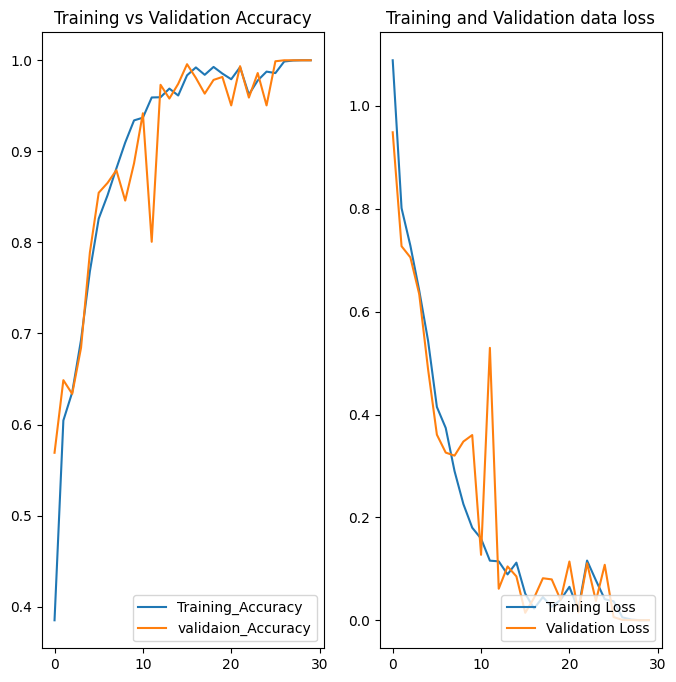

In [37]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = "Training_Accuracy")
plt.plot(range(EPOCHS), val_acc , label  = "validaion_Accuracy")
plt.legend(loc = 'lower right')
plt.title("Training vs Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss, label = "Training Loss")
plt.plot(range(EPOCHS), val_loss , label = "Validation Loss")
plt.legend(loc = "lower right")
plt.title("Training and Validation data loss")
plt.show()

In [38]:
# Prediction of 1st Image:

First_image :
Actual_label Brownspot
1/1 [==============================] - 1s 840ms/step
Predicted labels :  Brownspot


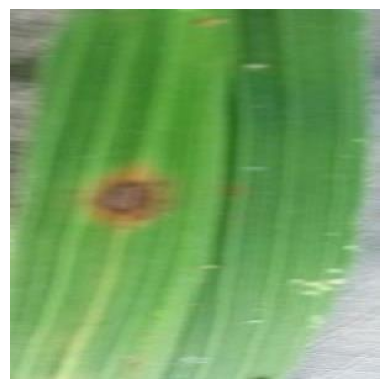

In [39]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    label_batch = label_batch[0].numpy()

    print("First_image :")
    plt.imshow(first_image)
    print("Actual_label",class_name[label_batch])

    prediction = model.predict(image_batch)
    print("Predicted labels : ",class_name[np.argmax(prediction[0])])
    plt.axis("off")

### Final_Prediction:

In [40]:
def predict(model, img):
    img_array  = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array= tf.expand_dims(img_array, 0)

    prediction = model.predict(img_array)

    predicted_class= class_name[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])))
    return predicted_class, confidence

1/1 [==============================] - 0s 51ms/step


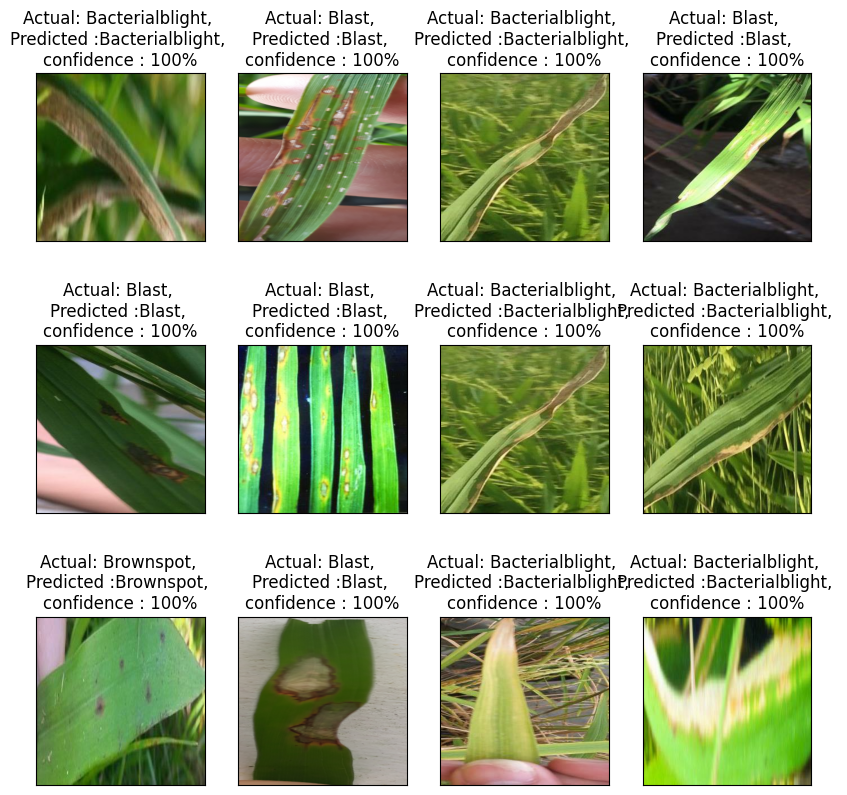

In [41]:
plt.figure(figsize = (10,10))

for images, labels in test_ds.take(1):
    for i in range(12):
        plt.subplot(3,4,i + 1, xticks = [], yticks = [])
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence  = predict(model ,images[i].numpy())
        actual_class = class_name[labels[i]]


        plt.title(f"Actual: {actual_class}, \nPredicted :{predicted_class}, \nconfidence : {confidence}%")

#### Conclusion:

1. **Model Architecture:**
   - Utilized a Convolutional Neural Network (CNN) for rice leaf disease prediction, designed to capture intricate patterns and features in leaf images.

2. **Data Exploration and Preprocessing:**
   - Visualized a subset of the dataset to understand its characteristics, ensuring effective preprocessing, including resizing, rescaling, and data augmentation for diverse model training.

3. **Data Augmentation:**
   - Implemented data augmentation techniques, such as random flips and rotations, to augment the dataset, preventing overfitting and enhancing the model's ability to generalize.

4. **Model Checkpointing:**
   - Incorporated model checkpointing to save the best-performing model weights during training, ensuring preservation of optimal parameters for future use.

5. **Project Impact:**
   - The project not only addresses the specific challenge of rice leaf disease prediction but also emphasizes the importance of thoughtful model design, data handling, and training methodologies in contributing to real-world applications, particularly in precision agriculture.